### Sources
LIME:
- https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16
- https://svitla.com/blog/interpreting-machine-learning-models-lime-and-shap
- https://towardsdatascience.com/understand-the-workings-of-black-box-models-with-lime-92203f906431
- https://algoritmaonline.com/interpreting-classification-model-with-lime/
- https://www.freecodecamp.org/news/interpret-black-box-model-using-lime/
- 

SHAP:


Inspiration for source code:
- https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification/code
- https://www.kaggle.com/code/ashutoshsinha/cs-go-round-winner-classification
- https://www.kaggle.com/code/cheedcheed/what-features-predict-the-winner-lightgbm-shap

- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
- https://towardsdatascience.com/interpretable-machine-learning-models-aef0c7be3fd9
- https://github.com/henniedeharder/interpretability-heart/blob/master/Demo_Forest_SHAP_Heart.ipynb
- https://www.kaggle.com/code/haobillylee/league-of-legends
- https://www.kaggle.com/code/ashutoshsinha/cs-go-round-winner-classification
- https://www.kaggle.com/code/timurrashitov/cs-go-match-outcome-with-neural-network-90
- https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/
- https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a
- https://github.com/slundberg/shap
- https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#import lightgbm as lgb
import shap
import lime
from lime import lime_tabular
import warnings
import logging
logging.getLogger('shap').setLevel(logging.WARNING)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.tree import export_graphviz
#from IPython.display import Image
#import pydotplus
from six import StringIO  
from scipy.special import softmax


c:\Users\Daniel\Anaconda3\envs\dss\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load dataset 
df = pd.read_csv('csgo_round_snapshots.csv')
display(df.head(10))
display(df.describe())
print(df.shape)

#divide into x and y 
y = df['round_winner']                  #target values
x = df.drop(['round_winner'], axis=1)   #all other columns that target values

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


(122410, 97)


### Exploratory Data Analysis (EDA) 


T     62406
CT    60004
Name: round_winner, dtype: int64

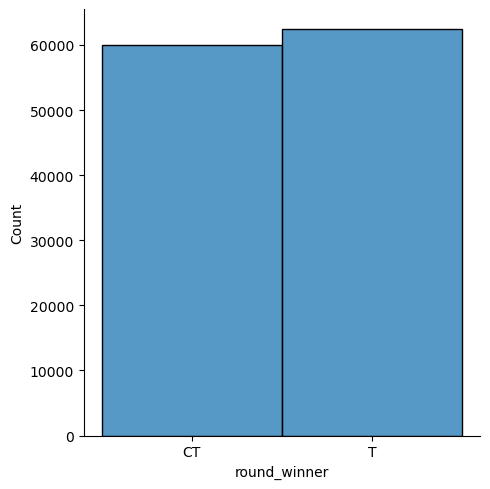

In [3]:
#number of round winners
sns.displot(df['round_winner'], kde=False)
df['round_winner'].value_counts()

map,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
round_winner,,,,,,,,
CT,103,10158,10810,9144,10214,7026,7310,5239
T,42,11986,13001,9432,8811,7055,6181,5898


<Axes: xlabel='round_winner', ylabel='count'>

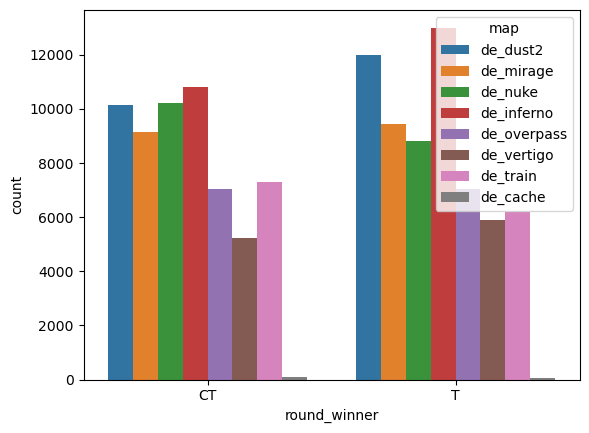

In [4]:
#comparing winners according to map 
display(pd.crosstab(df['round_winner'], df['map']))
sns.countplot(x='round_winner', hue='map', data=df)


### Data Preprocessing

In [5]:
"""
Check Columns (Null and non-numeric values)
"""
#null columns 
print("Columns:\n", df.isnull().any())
print("\nNumber of NULL columns:", df.isnull().sum().sum(), "\n")

#non-numeric values
display(df.drop(df.select_dtypes(np.number), axis = 1))


Columns:
 time_left                    False
ct_score                     False
t_score                      False
map                          False
bomb_planted                 False
                             ...  
ct_grenade_molotovgrenade    False
t_grenade_molotovgrenade     False
ct_grenade_decoygrenade      False
t_grenade_decoygrenade       False
round_winner                 False
Length: 97, dtype: bool

Number of NULL columns: 0 



,map,bomb_planted,round_winner
0,de_dust2,False,CT
1,de_dust2,False,CT
2,de_dust2,False,CT
3,de_dust2,False,CT
4,de_dust2,False,CT
...,...,...,...
122405,de_train,True,T
122406,de_train,False,T
122407,de_train,False,T
122408,de_train,False,T


In [6]:
"""
Encode features
"""
#one hot encode map and bomb_planted 
oneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

x_encoded = pd.DataFrame(oneHotEncoder.fit_transform(x[['map', 'bomb_planted']]))
x_encoded.columns = oneHotEncoder.get_feature_names_out(['map', 'bomb_planted'])
x_encoded.index = x.index

#insert encoded variables back into dataset
numerical_x = x.drop(['map', 'bomb_planted'], axis=1)
x = pd.concat([numerical_x, x_encoded], axis=1)

#encode target values as they have value true/false
labelEncoder = LabelEncoder()
labelEncoder.fit(y)
y = labelEncoder.transform(y)


#check if variables are encoded
map_mapping = {index : label for index, label in enumerate(oneHotEncoder.categories_)}
round_mapping = {index : label for index, label in enumerate(labelEncoder.classes_)}
print("Maps encoding: ", map_mapping, "\nRound Winner encoding: ", round_mapping)

Maps encoding:  {0: array(['de_cache', 'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke',
       'de_overpass', 'de_train', 'de_vertigo'], dtype=object), 1: array([0., 1.])} 
Round Winner encoding:  {0: 'CT', 1: 'T'}


In [7]:
"""
Prepare for training and testing
"""
#normalize data
scaler = RobustScaler()
scaled_x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns)

# Splitting the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=42)


#lightgbm model
#lgb_train = lgb.Dataset(x_train, label=y_train)
#lgb_test = lgb.Dataset(x_test, label=y_test)

### Training and Testing

In [8]:
"""
Random Forest Classifier
"""
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=22)
#model = RandomForestClassifier(random_state=22)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))
print('Precision on train: ' + str(precision_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))
print('Precision on test:  ' + str(precision_score(y_test, y_test_pred)))


Accuracy on train:  0.7501838085123764
Recall on train:    0.7436107995513539
Precision on train: 0.7609551137528182
Accuracy on test:   0.7505105792010457
Recall on test:     0.7421061067478762
Precision on test:  0.7621399176954733


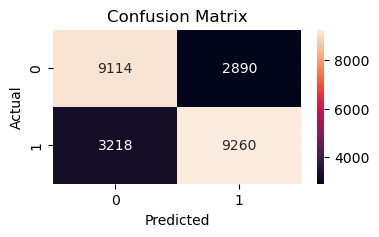

In [9]:
"""
Confusion matrix
"""
y_pred = np.where(y_test_pred > 0.5, 1, 0)

#create confusion matrix
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.show()

### Interpretability Methods

In [10]:
"""
SHAP
"""
#initialize 
shap.initjs()

#create explainer and get shap values
explainer = shap.Explainer(model, x_train)
shap_values = explainer.shap_values(x_test)



In [11]:
#Get the coefficients of the features
coefs = model.coef_

#Print the coefficients of the features
for i, feature in enumerate(x.columns):
    print("{}: {}".format(feature, coefs[0][i]))



time_left: 0.16962020873083364
ct_score: -0.030575225324122796
t_score: 0.028510376313273272
ct_health: -0.7245636220428688
t_health: 0.6342666592510892
ct_armor: -0.8376644730205713
t_armor: 0.8183601010458326
ct_money: -0.20254086316064498
t_money: 0.18656020597216239
ct_helmets: -0.010192868937636608
t_helmets: 0.7355177258694586
ct_defuse_kits: -0.035210898211840376
ct_players_alive: -0.3214906706197728
t_players_alive: 0.43545362855015946
ct_weapon_ak47: -0.35291480822778004
t_weapon_ak47: 0.81141241319713
ct_weapon_aug: -0.453985909549665
t_weapon_aug: 0.3349179940967639
ct_weapon_awp: -0.477440605135909
t_weapon_awp: 0.45042759968447604
ct_weapon_bizon: 0.0
t_weapon_bizon: 0.40176291818889454
ct_weapon_cz75auto: -0.04371023857677486
t_weapon_cz75auto: 0.12062828594243055
ct_weapon_elite: -0.17617960167695584
t_weapon_elite: 0.29504665661094504
ct_weapon_famas: -0.39100896893745385
t_weapon_famas: 0.6992094377826412
ct_weapon_g3sg1: 0.0
t_weapon_g3sg1: 0.43309904684192574
ct_weap

Index(['ct_weapon_awp', 'ct_players_alive', 't_weapon_sg553', 't_armor',
       't_health', 'ct_armor', 't_players_alive', 'ct_weapon_m4a4',
       't_weapon_ak47', 'ct_health'],
      dtype='object')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


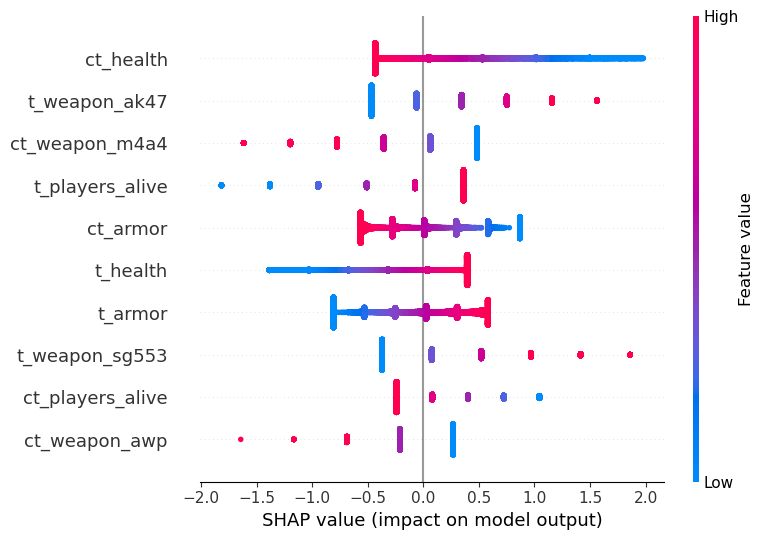

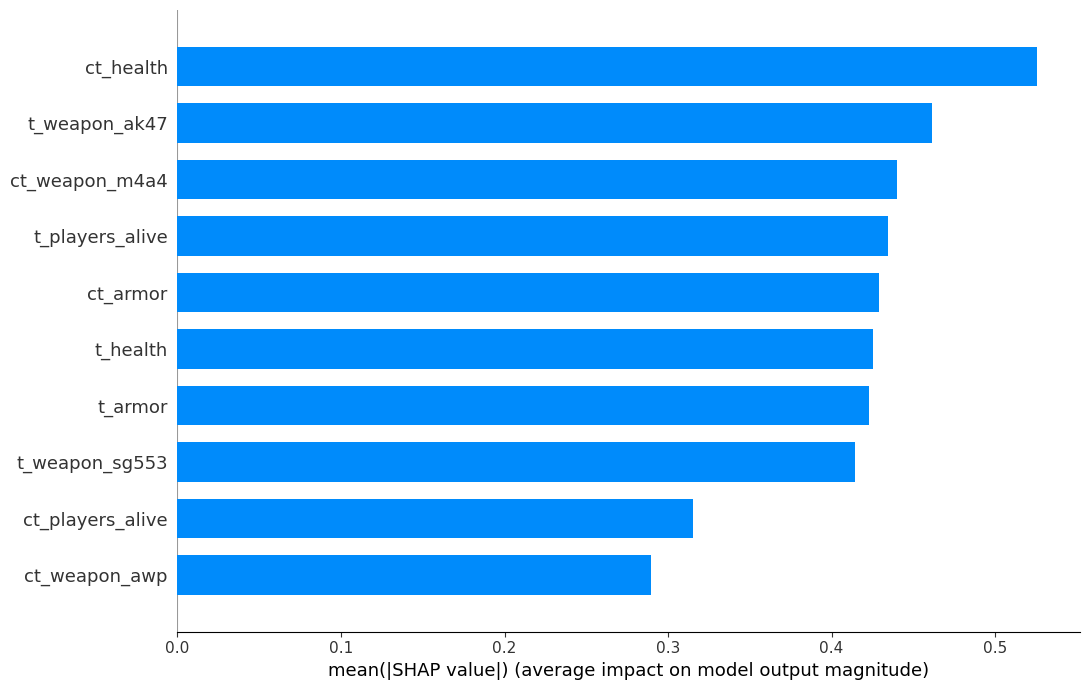

In [12]:
"""
Summary plot
"""
k = 10
feature_names = x.columns

#getting the top 10 features 
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap_values)[-k:]
top_features = x.columns[top_features_idx]

print(top_features)

#beeswarm plot
shap.summary_plot(shap_values, x_test, feature_names=feature_names, max_display=k)

#bar plot
shap.summary_plot(shap_values, x_test, plot_type="bar", feature_names=feature_names, max_display=10, plot_size = (11,7))


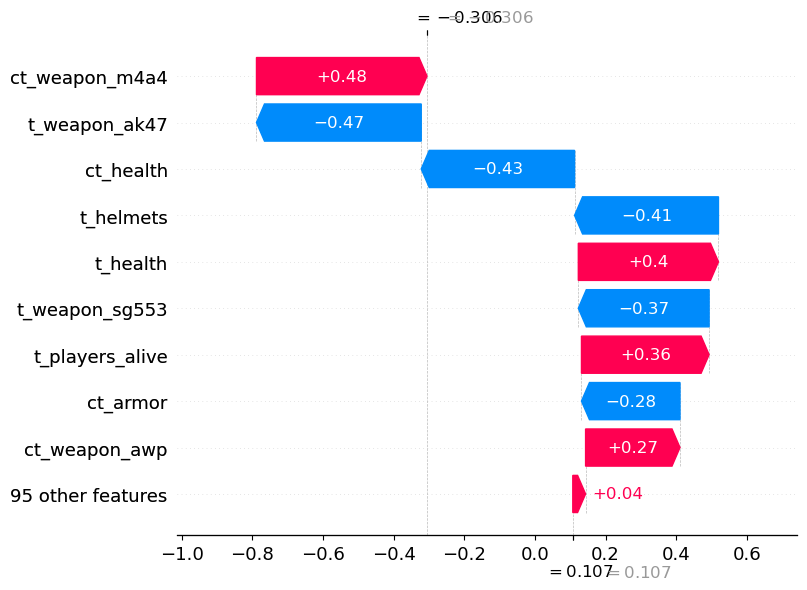

In [13]:
"""
Waterfall plot
"""
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=feature_names, max_display=10)

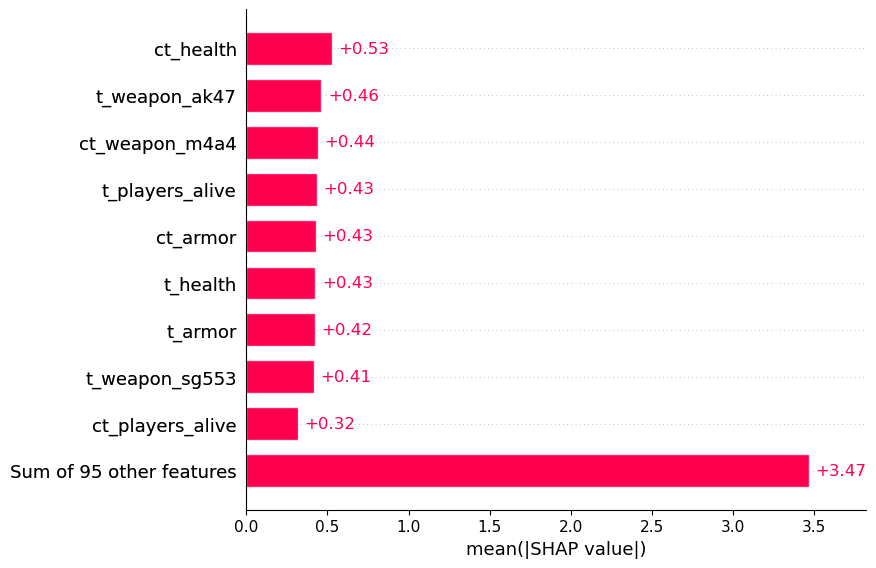

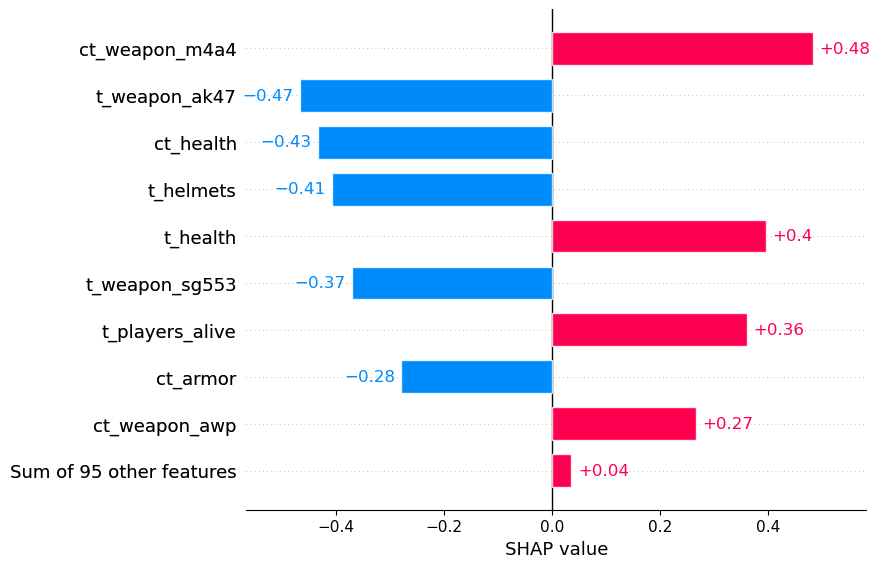

In [14]:
"""
Bar plot
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
"""
sample_ind = 25

#global bar plot
shap.plots.bar(explainer(x_test), max_display=10)

#local bar plot
shap.plots.bar(explainer(x_test)[0], max_display=10)


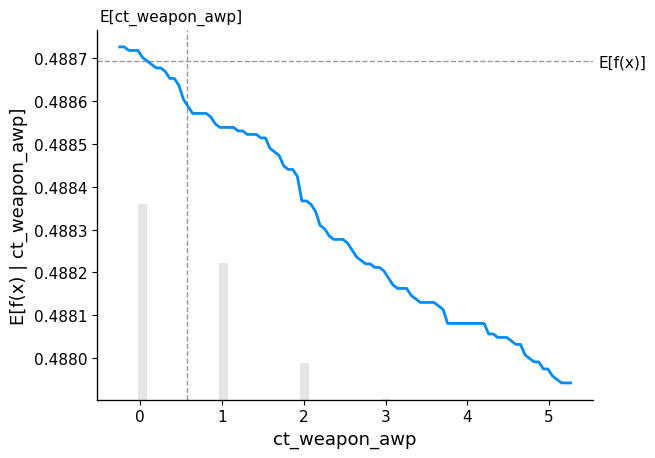

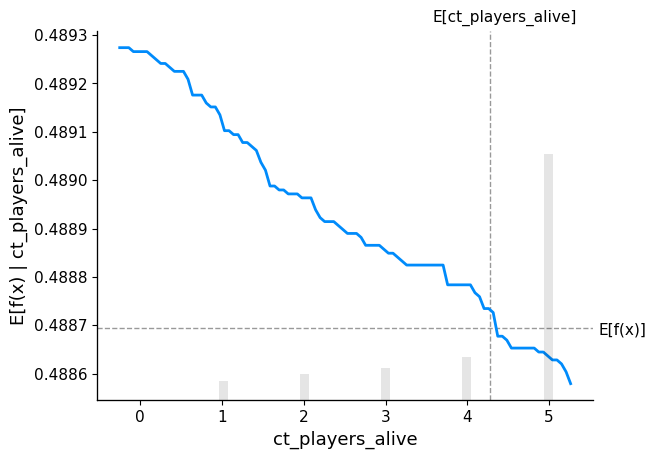

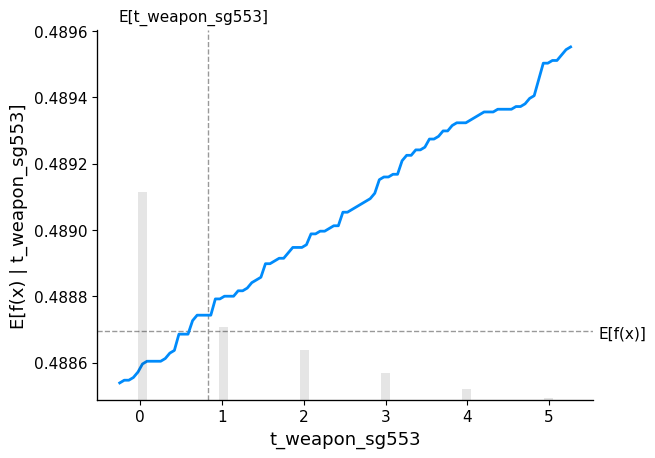

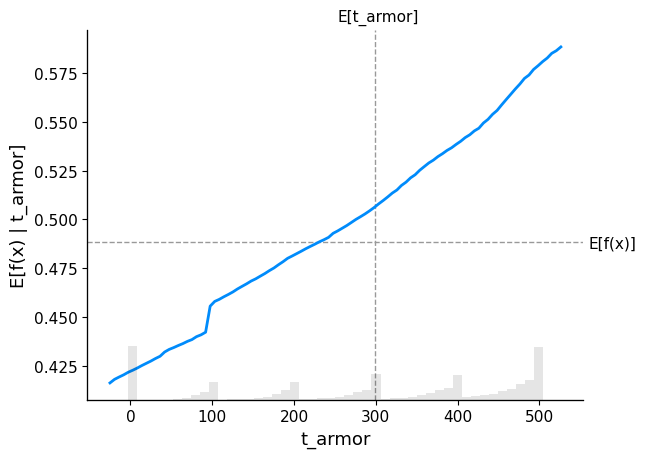

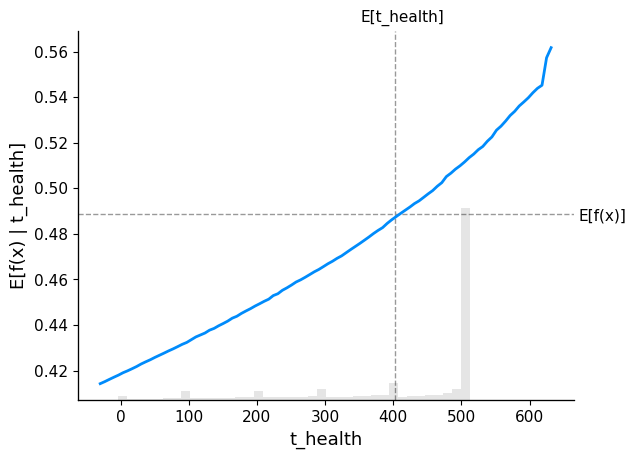

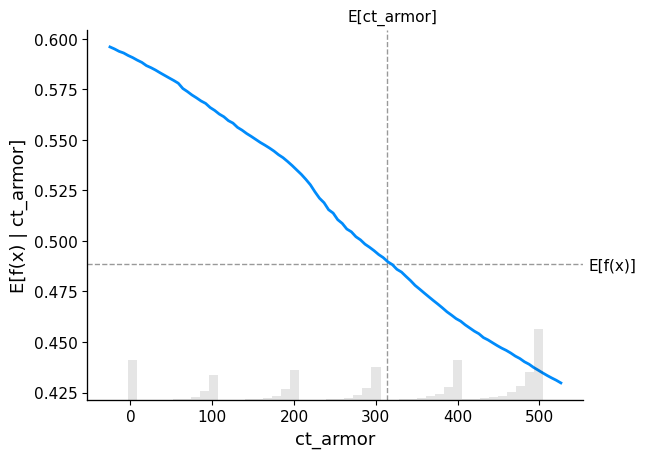

In [15]:
"""
Partial dependence plot 
"""
plot_num = 6 #number of plots

for f in top_features[:plot_num]:
    shap.partial_dependence_plot(
        f, model.predict, x, ice=False,
        model_expected_value=True, feature_expected_value=True
    )


[Text(0.5, 0.03, 'ct_weapon_awp'),
 Text(1.5, 0.03, 'ct_players_alive'),
 Text(2.5, 0.03, 't_weapon_sg553'),
 Text(3.5, 0.03, 't_armor'),
 Text(4.5, 0.03, 't_health'),
 Text(5.5, 0.03, 'ct_armor'),
 Text(6.5, 0.03, 't_players_alive'),
 Text(7.5, 0.03, 'ct_weapon_m4a4'),
 Text(8.5, 0.03, 't_weapon_ak47'),
 Text(9.5, 0.03, 'ct_health')]

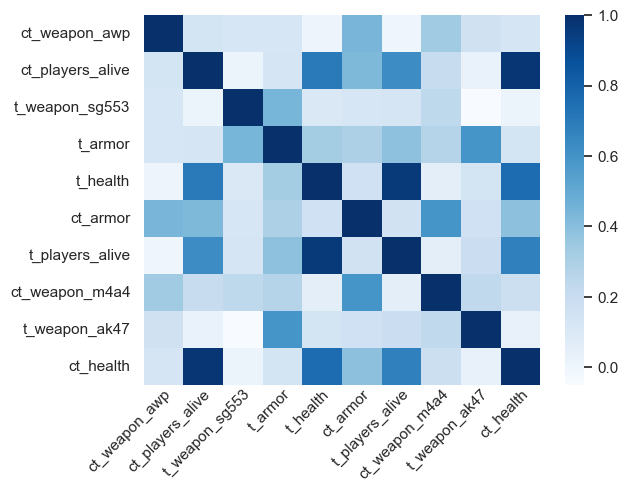

In [16]:
"""
Correlation matrix
"""
# Create a heatmap of corralation between the top 20 features with perason method
corr = x[top_features[:k]].corr(method='pearson')
# Plot the heatmap as a square
sns.set()
ax = sns.heatmap(corr, annot=False, fmt='.2f', cmap='Blues', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', rotation_mode='anchor', y=0.03)

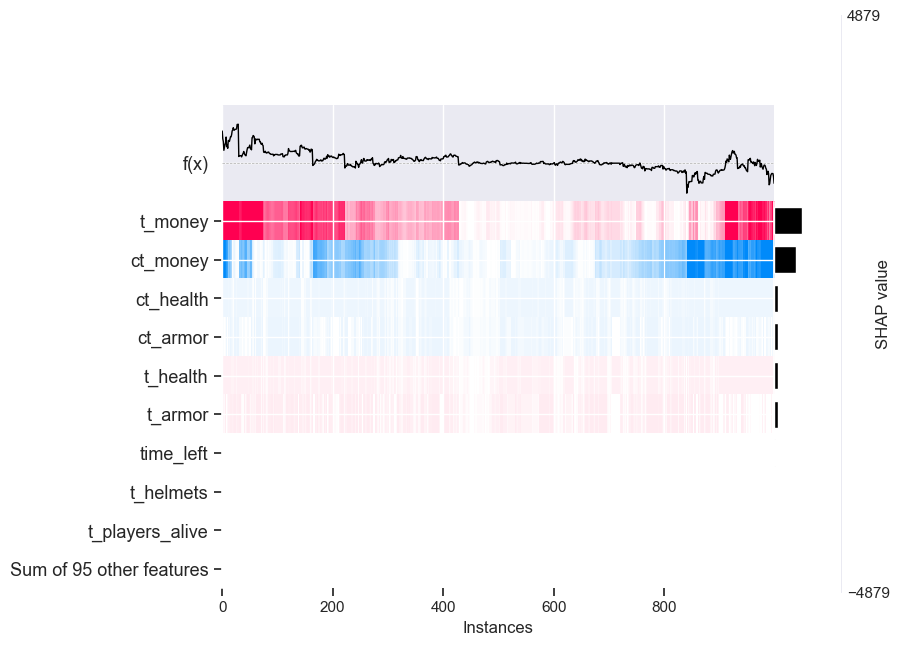

In [17]:
"""
Heatmap
"""
shap_values = explainer(x[:1000])
shap.plots.heatmap(shap_values, max_display=k)



In [18]:
"""
Force plot 
"""
instance_idx = 25
instance = x.iloc[[instance_idx]]
shap_values = explainer.shap_values(instance)

shap.force_plot(explainer.expected_value, shap_values, instance)



Permutation explainer: 1001it [00:42, 17.87it/s]                         


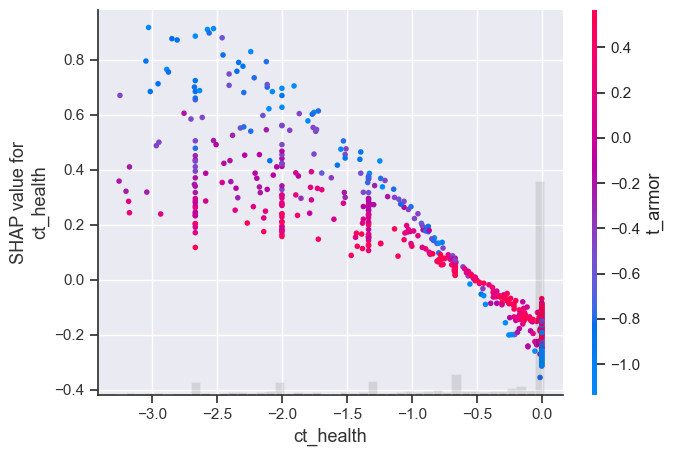

In [23]:
"""
Scatter plot 
"""
explainer = shap.Explainer(lambda x: model.predict_log_proba(x)[:,1], x_train)
shap_values = explainer(x_train[:1000])
shap.plots.scatter(shap_values[:,"ct_health"], color=shap_values)


In [ ]:
"""
LIME
"""
#create test
i = 10
test_1 = x_test.iloc[i]

#create lime explainer
explainer = lime_tabular.LimeTabularExplainer(training_data= np.array(x_train),                                               
                                                   mode='classification',
                                                   class_names=['CT', 'T'],                                                 
                                                   feature_names=feature_names)

#define plot 
exp = explainer.explain_instance(
    data_row = test_1,
    predict_fn = model.predict_proba, 
    num_features=k)

exp.show_in_notebook(show_table=True)
#exp.as_pyplot_figure()
#plt.show()